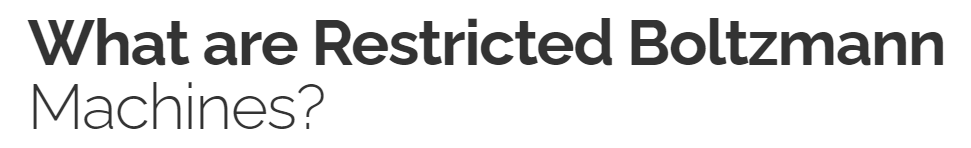
### In this tutorial, we’ll talk about the Restricted Boltzmann Machine (RBM), a generative stochastic unsupervised learning algorithm.

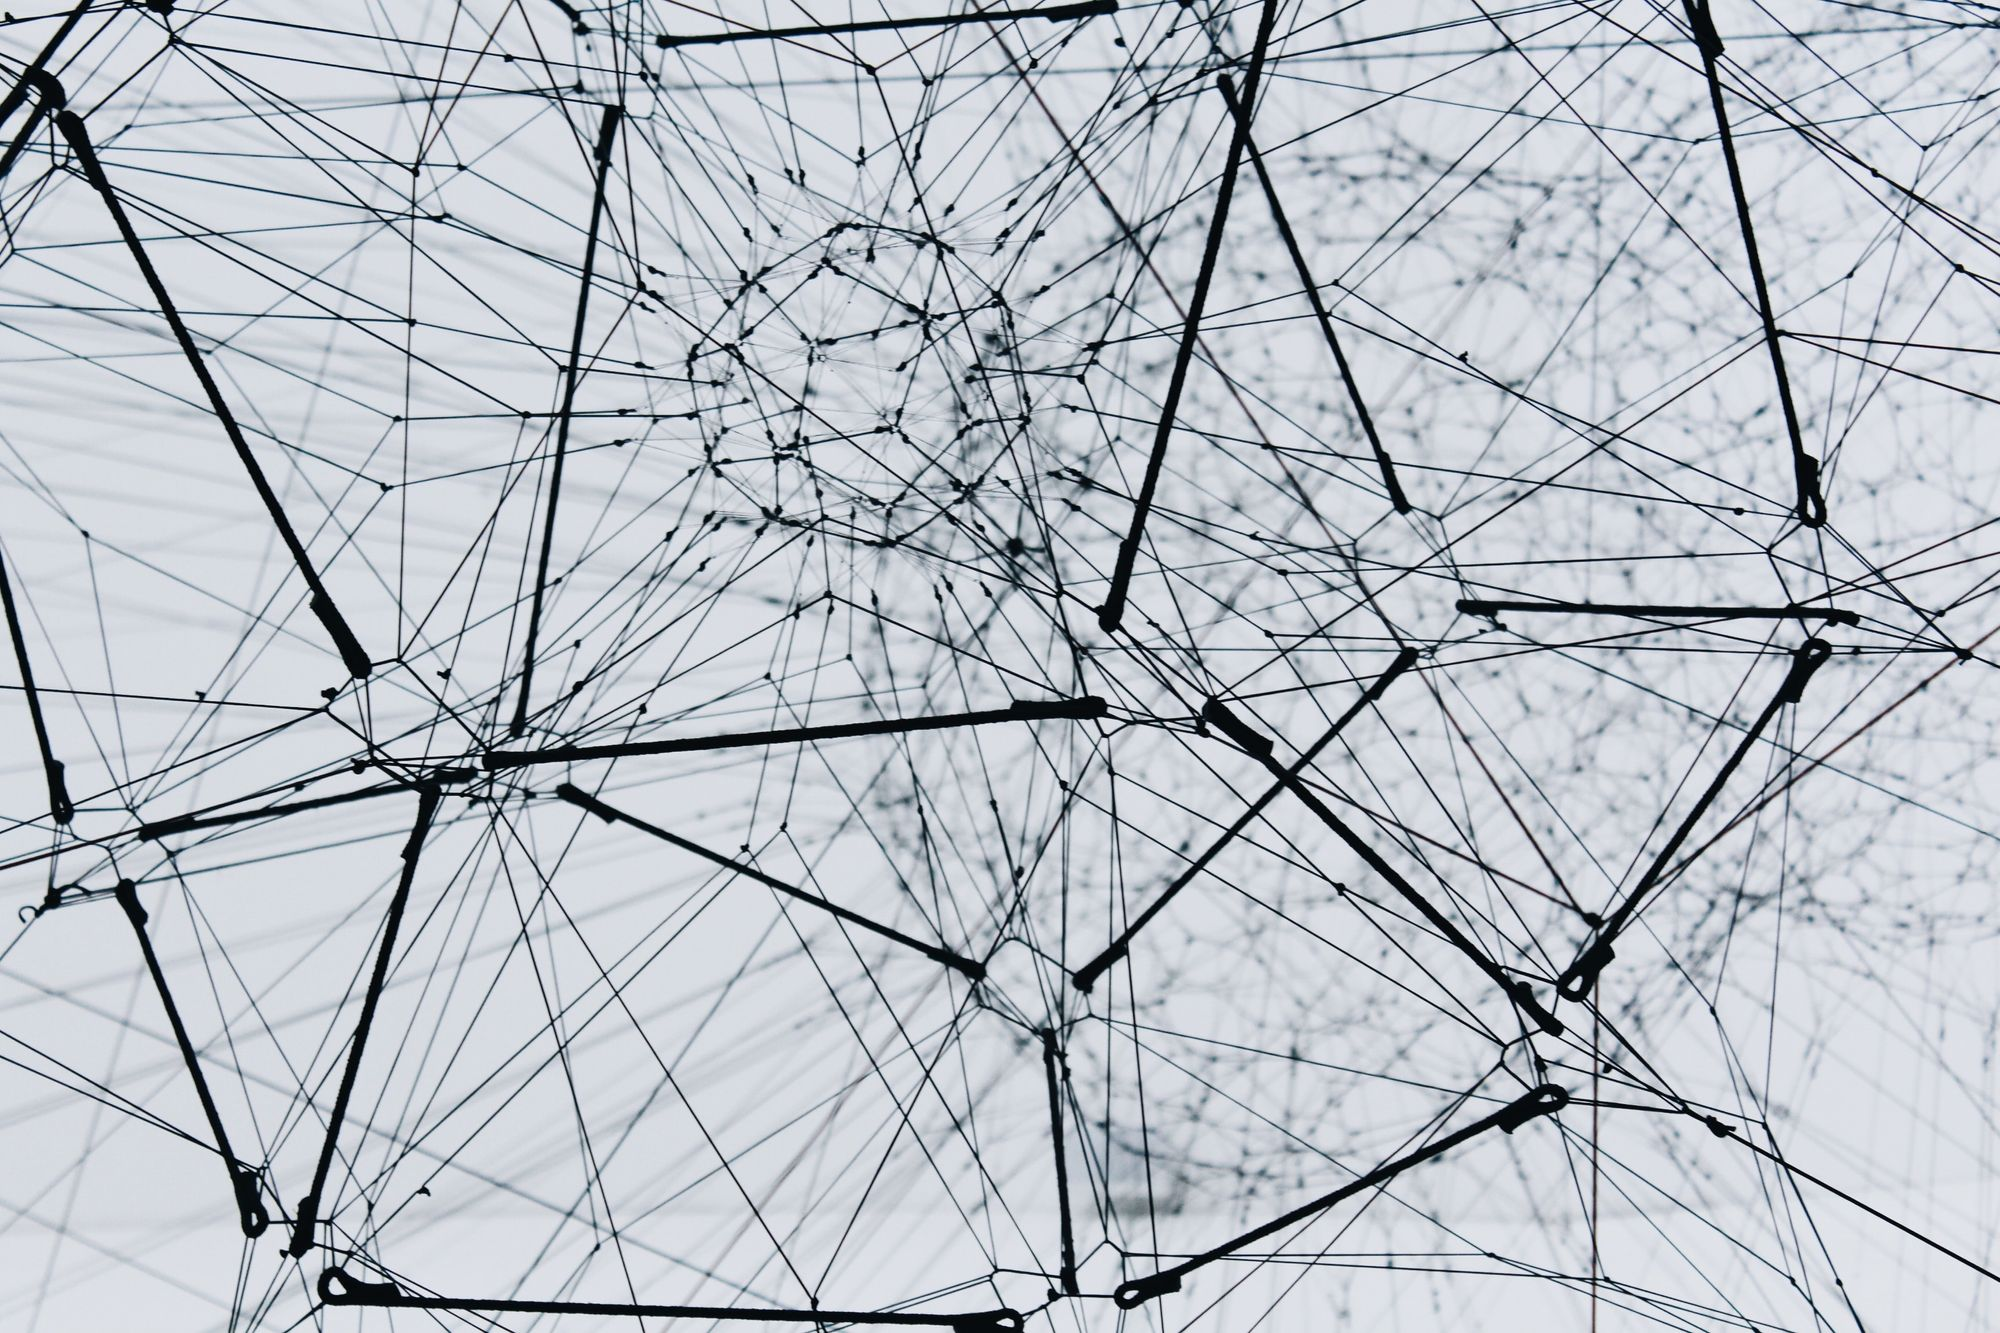

# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">TABLE OF CONTESTS</p>

    
* [1. INTRODUCTION](#1)
    * [1.1 What Are Boltzmann Machines?](#1.1)
    * [1.2 Restricted Boltzmann Machines](#1.2)
    
    
    
* [2. Implementation of RBMs in PyTorch](#2)
    
* [3. Importing the required libraries](#3)
        
* [4. Loading the MNIST Dataset](#4)  
    
* [5. Defining the Model](#5) 
      
* [6. Initialising and Training the Model](#6)
    
* [7. Visualising the Outputs](#7)
    
* [8. END](#8)


<a id="1"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">1. INTRODUCTION</p>
    
### In this tutorial, we’ll talk about the Restricted Boltzmann Machine (RBM), a generative stochastic unsupervised learning algorithm. Mainly, we’ll go deep into the Restricted Boltzmann Machine’s (RBM) architecture, and we will walk through its learning procedure.



    

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
 <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">1.1 What are Bultzmann Machines?</p>   
Unlike other neural network models that we have seen so far, the architecture of Boltzmann Machines is quite different. There is no clear demarcation between the input and output layer. In fact, there is no output layer. The nodes in Boltzmann Machines are simply categorized as visible and hidden nodes. The visible nodes take in the input. The same nodes which take in the input will return back the reconstructed input as the output. This is achieved through bidirectional weights which will propagate backwards and render the output on the visible nodes.

A major boost in the architecture is that every node is connected to all the other nodes, even within the same layer (for example, every visible node is connected to all the other visible nodes as well as the hidden nodes). All the links are bidirectional and the weights are symmetric. Below is an image explaining the same.
    
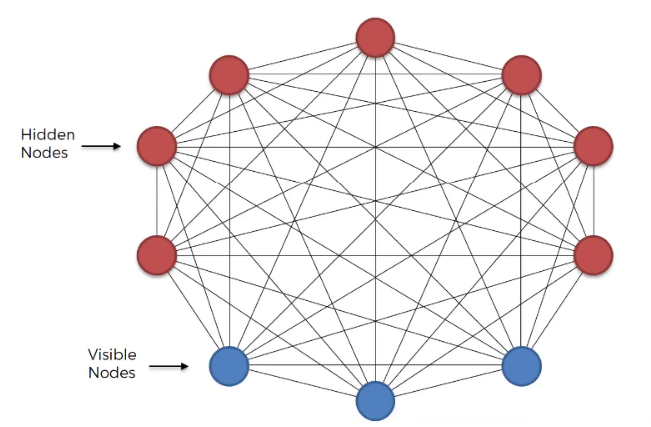

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
 <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">1.2 Restericted Bultzmann Machines</p> 
    The architecture of a Restricted Boltzmann Machine (RBM) consists of two layers of interconnected nodes: an input layer and a hidden layer with symmetrically connected weights. As we can see in the diagram below, each node in the input layer is connected to each node in the hidden layer, with each connection having a weight associated with it. Also, there are no connections between nodes of the hidden or the visible layer respectively:
    
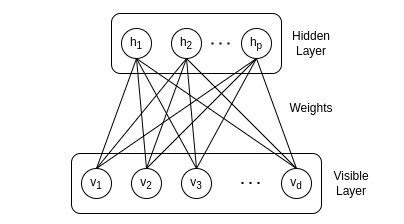
    
    The set of neurons in the hidden layer represents the probability distribution across the input data. During training, the system updates the weights between the layers aiming to reproduce the desired output values. The purpose of each neuron in the visible layer is to observe a pattern of data, while the neurons in the hidden layer are used to explain the pattern observed by the visible neurons.
    

<a id="2"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">2. Implementation of RBMs in PyTorch</p>

In this section, we shall implement Restricted Boltzmann Machines in PyTorch. We shall be building a classifier using the MNIST dataset. Amongst  the wide variety of Boltzmann Machines which have already been introduced, we will be using Restricted Boltzmann Machine Architecture here. Below are the steps involved in building an RBM from scratch.

<a id="3"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">3. Importing the required libraries</p>
    

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

base_dir = '/Users/yishai/Desktop/GenerativeTabularFusion'
import os
os.chdir(base_dir)    
from app.dotenv import base_dir, data_dir

In [2]:
batch_size = int(os.getenv('batch_size'))# batch size
n_epochs = int(os.getenv('n_epochs')) # number of epochs
lr = float(os.getenv('lr')) # learning rate
n_hid = int(os.getenv('n_hid')) # number of neurons in the hidden layer
n_vis = int(os.getenv('n_vis')) # input size. i.e number of neurons in the visible layer

print(f'batch_size: {batch_size}')
print(f'n_epochs: {n_epochs}')
print(f'lr: {lr}')
print(f'n_hid: {n_hid}')
print(f'n_vis: {n_vis}')

batch_size: 64
n_epochs: 10
lr: 0.01
n_hid: 128
n_vis: 784


<a id="4"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">4. Loading the MNIST Dataset</p>
In this step, we will be using the MNIST Dataset using the DataLoader class of the torch.utils.data library to load our training and testing datasets. We set the batch size to 64 and apply transformations.

In [3]:
# batch_size = 64

from app.load_data.MNIST import data_loaders
train_loader, test_loader = data_loaders(batch_size,data_dir)


# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor()
#                    ])),
#     batch_size=batch_size)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor()
#                    ])),
#     batch_size=batch_size)



train size:  60000 test size:  10000
batch size: torch.Size([64, 1, 28, 28])


<a id="5"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">5. Defining the Model</p>
In this step, we will start building our model. We will define the transformations associated with the visible and the hidden neurons. Also, since a Boltzmann Machine is an energy-model, we also define an energy function to calculate the energy differences. In the initialization function, we also initialize the weights and biases for the hidden and visible neurons.

In [ ]:
from app.rbm.model import RBM_v2

RBM = RBM_v2



As we have seen earlier, in the end, we always define the forward method which is used by the Neural Network to propagate the weights and the biases forward through the network and perform the computations. The process is repeated for k times, which defines the number of times contrastive divergence is computed. Since Boltzmann Machines are energy based machines, we now define the method which calculates the energy state of the model.

<a id="6"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">6. Initialising and Training the Model</p>
The RBM class is initialized with k as 1. We will be using the SGD optimizer in this example. At the end of the process we would accumulate all the losses in a 1D array for which we first initialize the array. We extract a Bernoulli's distribution using the data.bernoulli() method. This is the input pattern that we will start working on.

The generated pattern is next fed to the rbm model object. The model returns the pattern that it was fed and the calculated pattern as the output. The loss is calculated as the difference between the energies in these two patterns and appends it to the list. As discussed earlier, since the optimizer performs additive actions, we initially initialize the accumulators to zero. The loss is back propagated using the backward() method. optimizer.step() performs a parameter update based on the current gradient (accumulated and stored in the .grad attribute of a parameter during the backward() call) and the update rule.

In [5]:
model = RBM(k=1)
train_op = optim.SGD(model.parameters(),lr=lr)

for epoch in range(n_epochs):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = model(sample_data)
        loss = model.free_energy(v) - model.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -19.53156089782715
Training loss for 1 epoch: -14.32148265838623
Training loss for 2 epoch: -14.065492630004883
Training loss for 3 epoch: -13.45490550994873
Training loss for 4 epoch: -13.006877899169922
Training loss for 5 epoch: -12.56175422668457
Training loss for 6 epoch: -11.924180030822754
Training loss for 7 epoch: -11.487950325012207
Training loss for 8 epoch: -10.97451400756836
Training loss for 9 epoch: -10.573989868164062


In the below code snippet, we have defined a helper function in which we transpose the numpy image to suitable dimensions and store it in local storage with the name passed as an input to the function.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

<a id="7"></a>
# <p style="background-color:#0F0F0F;font-family:newtimeroman;color:#FFEBCD;font-size:120%;text-align:center;border-radius:40px 40px;">7. Visualising the Outputs</p>

## Real data

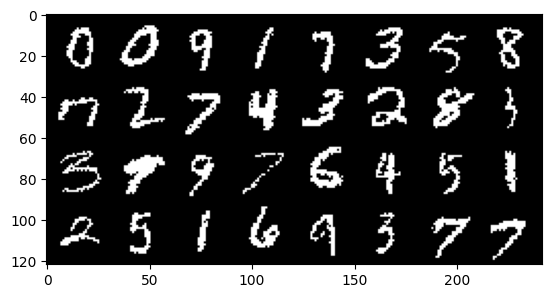

In [7]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

## Generate after learning

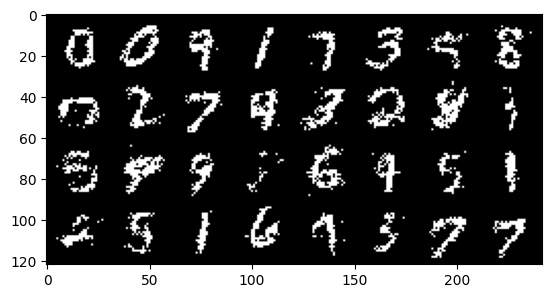

In [8]:
show_adn_save("generate",make_grid(v1.view(32,1,28,28).data))